# Modeling

# 1) Importing key modules

In [1]:
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np
import os
import string
import re

In [4]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

In [5]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


# 2) Loading preprocessed dataset

In [6]:
data = pd.read_csv('self_drive.csv', encoding="utf8")
data.head()

,sentiment,text
0,5,@manjulamartin @Kirk_Gleason Except trains are...
1,5,I want a Google driverless car.
2,5,@Oatmeal @google driverless @TeslaMotors ? Ooo...
3,5,SO MUCH AWESOME! Amazing video for GoogleÌ¢‰âÂ...
4,5,@google is making driverless cars which is awe...


In [7]:
print(data.text.duplicated().sum())

0


In [8]:
data.sentiment.value_counts()

3    603
4    179
2    117
5     59
1     23
Name: sentiment, dtype: int64

In [9]:
data.shape

(981, 2)

In [10]:
data['sent_type'] = data.sentiment.map({ 1 :'Negative', 2:'Negative',4:'Positive', 5:'Positive',3:'Neutral'})

In [11]:
data.sent_type.value_counts()

Neutral     603
Positive    238
Negative    140
Name: sent_type, dtype: int64

In [12]:
data=data.drop(['sentiment'], axis=1)

In [13]:
data.head()

,text,sent_type
0,@manjulamartin @Kirk_Gleason Except trains are...,Positive
1,I want a Google driverless car.,Positive
2,@Oatmeal @google driverless @TeslaMotors ? Ooo...,Positive
3,SO MUCH AWESOME! Amazing video for GoogleÌ¢‰âÂ...,Positive
4,@google is making driverless cars which is awe...,Positive


In [14]:
data.to_pickle('self_drive_model.pkl')

## 3) Preprocessing  for modeling

### a) Splitting dataset

In [15]:
train, test = train_test_split(data, random_state = 42, test_size=0.1)
print(train.shape)
print(test.shape)

(882, 2)
(99, 2)


In [16]:
train.head()

,text,sent_type
629,FBI Concerned About Criminals Using Driverless...,Neutral
424,Secrets to Google driverless cars! @TODAYshow ...,Neutral
715,"""@DanielBurrus: Volvo Is About To Put 100 Driv...",Neutral
692,Driverless car + Mobile LiDAR: @sustaincities:...,Neutral
712,The solution for parents who have to drive the...,Neutral


### b) training constt

In [17]:
MAX_SEQ_LEN = 25 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 128

### c) Let's clean

In [18]:
# Mapping of common contractions, could probbaly be done better
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                       "It's": 'It is', "Can't": 'Can not',
                      }

In [19]:
def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    # Random note: removing the URL's slightly degraded performance, it's possible the model learned that certain URLs were positive/negative
    # And was able to extrapolate that to retweets. Could also explain why re-training the Embeddings improves performance.
    # remove twitter url's
        text = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*","TWITTERURL",text)
    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(t)
    return ' '.join(mapped_string)

In [20]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)
train_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in train['text'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in test['text'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train["text"].values[0])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 3683
Max Token Index: 3683 

Sample Tweet Before Processing: FBI Concerned About Criminals Using Driverless Cars http://t.co/YRxAy75BYY via @slashdot
Sample Tweet After Processing: ['FBI Concerned About Criminals Using Driverless Cars TWITTERURL via slashdot'] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 115, 1195, 387, 515, 1196, 8, 23, 2, 42, 1197]


**Of course we could more cleaning and we can use other methods. We will keep it simple and easy for start. Perhaps at later stage, we use other techniques**

### d) Dealing with categorical variables 
sentiment is classified as Negative, Neutral or Positive. To make it suitable for a deep learning model each sentiment will be converted to a vector of length 3, where each position corresponds to a sentiment class: Negative = 0, Neutral = 1 and Positive = 2

In [21]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['sent_type'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['sent_type'].values)
y_test = to_categorical(y_test) 

In [22]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(train['sent_type'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)
cws = class_weight.compute_class_weight('balanced', np.unique(y_train_int), y_train_int)
print(cws)

Distribution of Classes: Counter({'Neutral': 538, 'Positive': 217, 'Negative': 127})
[2.31496063 0.5464684  1.35483871]


# 4) Model

### i-Baselines
- Use Dominant class
- Use Naive bayes and Random Forest ML
- Compare with DL algorithms

In [23]:
# confusion matrix define
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.set_printoptions(precision=4)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    classes = classes[unique_labels(y_true, y_pred)]
    _cm = confusion_matrix(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=classes))
        
    def _build_matrix(fig, ax, cm, normalize = False):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, cmap=cmap)
#         fig.colorbar(im, ax=ax)
        
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
    fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
    _build_matrix(fig, ax1, cm = _cm, normalize=False)
    _build_matrix(fig, ax2, cm = _cm, normalize=True)
    fig.tight_layout()

In [24]:
print('Dominant Class: ', ctr.most_common(n = 1)[0][0])
print('Baseline Accuracy Dominant Class', (ctr.most_common(n = 1)[0][0] == test['sent_type'].values).mean())

preds = np.zeros_like(y_test) # its kind of close to what null accuracy does. We are checking acc. of neg sentiment
preds[:, 0] = 1
preds[0] = 1 #done to suppress warning from numpy for f1 score
print('F1 Score:', f1_score(y_test, preds, average='weighted'))

Dominant Class:  Neutral
Baseline Accuracy Dominant Class 0.6565656565656566
F1 Score: 0.050379334470243564


**From here, we get a rough idea what our accuracy and F1 scores could be. Let's see if our models improve on this or not !!!**

### ii-Naive Bayes

Baseline Accuracy Using Naive Bayes:  0.6666666666666666
F1 Score: 0.5429250677438072
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        13
     Neutral       0.66      1.00      0.80        65
    Positive       1.00      0.05      0.09        21

   micro avg       0.67      0.67      0.67        99
   macro avg       0.55      0.35      0.30        99
weighted avg       0.65      0.67      0.54        99



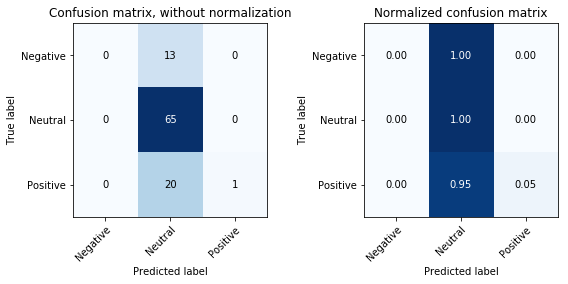

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using Naive Bayes: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

_ = plot_confusion_matrix(y_test.argmax(axis = 1), predictions, classes=encoder.classes_, title='Confusion matrix, without normalization')

Naive Bayes is a good baseline, but is not robust to imblanced datasets, common with classification of "real-world" data.In this case rebalancing the data would require throwing away a lot of neutral examples or significantly oversampling the positive/negative cases. 

### iii- Random Forest

Baseline Accuracy Using RFC:  0.7575757575757576
F1 Score: 0.7095467663649482
              precision    recall  f1-score   support

    Negative       1.00      0.23      0.38        13
     Neutral       0.73      1.00      0.84        65
    Positive       1.00      0.33      0.50        21

   micro avg       0.76      0.76      0.76        99
   macro avg       0.91      0.52      0.57        99
weighted avg       0.82      0.76      0.71        99



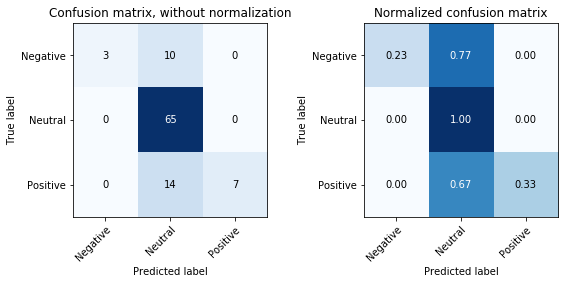

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=100)), #100 estimators will be the new default in version 0.22
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using RFC: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

_ = plot_confusion_matrix(y_test.argmax(axis = 1), predictions, classes=encoder.classes_)

The metric we'll be interested are Accuracy, which is self-explanatory and F1 Score, which blends the precision and recall scores for each class. F1 Score is generally a better measure of the performance of a model, especially when classes are imbalanced.

Between our Baselines the Random Forest Classifier performs the best by a large margin (mostly because it's robust to class imbalance).

Our goal is to see if we can produce a model that has a F1 Score > ~0.67


### iii- Neural Networks

In [27]:
#train the models
def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train(model, 
          X_train, y_train, X_test, y_test, 
          checkpoint_path='model.hdf5', 
          epcohs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
          class_weights = None, 
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        #this is bad practice using test data for validation, in a real case would use a seperate validation set
        validation_data=(X_test, y_test),  
        epochs=epcohs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 
    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()    
    return m #returns best performing model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 128)           471552    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 611,587
Trainable params: 611,587
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 882 samples, validate on 99 samples
Epoch 1/25
 - 1s - loss: 1.0742 - acc: 0.5680 - val_loss: 0.9938 - val_acc: 0.6566

Epoch 00001: v

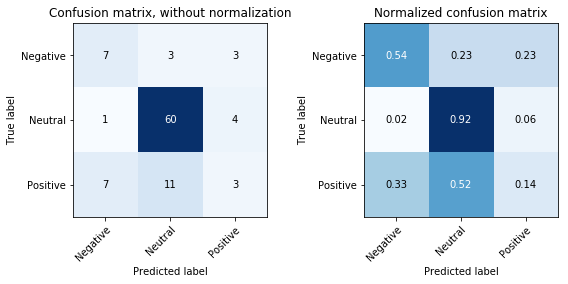

In [28]:
#simple implementation of an LSTM
def model_1():
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

m1 = train(model_1, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=cws
          )

we have a good baseline Neural Network Architecture we'll begin building on it. By adding more layers and increasing the complexity

### b-Bidiretional LSTM

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 128)           471552    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 25, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 751,363
Trainable params: 751,363
Non-trainable params: 0
_________________________________________________________________
None
Train on 882 sam

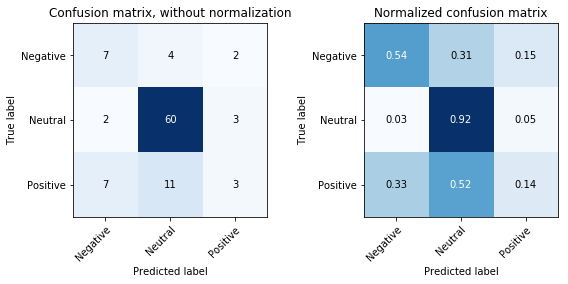

In [29]:
def model_1b():
    """
    Using a Bidiretional LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
    model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

_ = train(model_1b, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1b.h5',
           class_weights=cws,
           print_summary = True
          )

### c)Adding dropout to reduce overfitting

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 128)           471552    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 25, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 25, 256)           263168    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            65600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total para

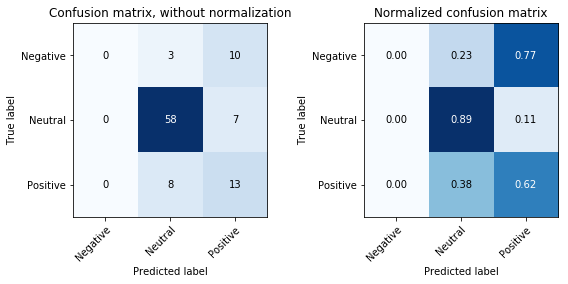

In [30]:
def model_1c():
    """
    Adding dropout to reduce overfitting using a bidiretional LSTM
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    return model


_ = train(model_1c, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1c.h5',
           class_weights=cws,
           print_summary = True
          )

### d)Convolutional NLP

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 128)           471552    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 25, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 64)            41024     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 19, 64)            12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18, 64)            8256      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
__________

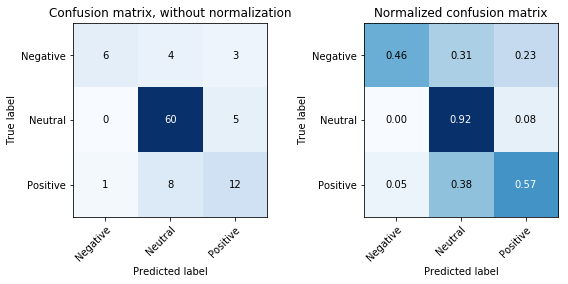

In [31]:
def model_1d():
    """
    Just for fun below is a model only using covolutions. This is pretty good and also trains very quickly(and predictions would also likely be fast) compared to the LSTM...
    It's equivalent to using an n-gram based approach.
    Usually in practice you would use a more complex architecture with multiple parallel convolutions that are combined before pooling(and usually both max and avg).
    Pure Convolutional NLP is definitely a solution worth exploring further.
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(64, 5))
    model.add(Conv1D(64, 3))
    model.add(Conv1D(64, 2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


_ = train(model_1d, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1d.h5',
           class_weights=cws,
           print_summary = True
          )

**When dealing with neural network, it is important to know that we are looking for Loss function now as key evaluation parameter.**

# Conclusion:
We got 0.73 loss from our neural network. Naive Bayes which is very reliable method in text classifier literature did not work that well. Do you wonder why?<br>

In most data science courses, we walk around all the new techniques and algorithms. But, we forget the focus. It's data cleaning. Have we cleaned our well enough? Answer is "not good enough". In my next excercises, I would work on more techniques of data cleaning than round 1 and round2. Then we will run our results again to see if there is any improvement.

In [32]:
from sklearn.metrics import confusion_matrix
print('Residuals Analysis:', )
print(confusion_matrix(y_test.argmax(axis = 1),preds.argmax(axis = 1)))


ctr = 0
for i in range(y_test.shape[0]):
    true_label = y_test[i].argmax()
    pred_label = preds[i].argmax()
    if true_label != pred_label:
        print('idx:', i)
        print('True Label:', encoder.classes_[true_label])
        print('Predicted Label:', encoder.classes_[pred_label])
        print('Probability Prediction', preds[i])
        print(test['sent_type'].values[i], '::',  test['text'].values[i], '\n')
        ctr += 1
    
    if ctr > 20:
        break

Residuals Analysis:
[[13  0  0]
 [65  0  0]
 [21  0  0]]
idx: 0
True Label: Neutral
Predicted Label: Negative
Probability Prediction [1. 1. 1.]
Neutral :: @AdamVolle Well, not without driverless cars, completely automated factories and stores, etc. Someone needs to be around to produce. 

idx: 1
True Label: Neutral
Predicted Label: Negative
Probability Prediction [1. 0. 0.]
Neutral :: DMV Hosts NorCal Workshop To Create Rules For Driverless Cars: SAN JOSE (CBS/AP) Ì¢‰âÂ‰Û With auto officials saying... http://t.co/NsAba7thQ3 

idx: 2
True Label: Positive
Predicted Label: Negative
Probability Prediction [1. 0. 0.]
Positive :: Can't wait for driverless vehicles to be the norm, obviously we are a while away cause it's still spell checked as a word :) 

idx: 3
True Label: Neutral
Predicted Label: Negative
Probability Prediction [1. 0. 0.]
Neutral :: Ever-vigilant DC cops pull over Google's driverless car. http://t.co/RltLZAUk Amazingly, no one was injured. 

idx: 4
True Label: Positive
Pre

**Even our model predicts so bad. Could it be only predicting issue or something else need to be done?**